In [324]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy import signal
from scipy.io import wavfile
import sounddevice as sd
from scipy.io.wavfile import write

%matplotlib inline

# Input one fixed audio

In [325]:
fft_length = 1024
fs = 44100  # Sample rate
seconds = 2  # Duration of recording

In [326]:
input_source = np.zeros(fft_length)
input_source[1] = 1

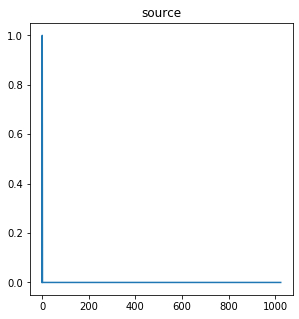

In [327]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
plt.title('source')
plt.plot(input_source)

# Generate DTF of the input

In [328]:
input_fft = np.fft.rfft(input_source, fft_length)
frequency = np.linspace(0,fs/2,len(input_fft))

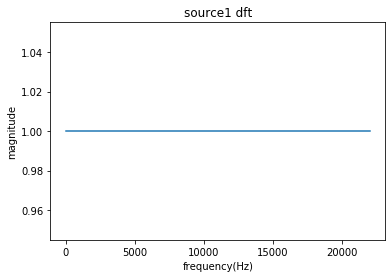

In [329]:
plt.figure()
plt.title("source1 dft")
plt.xlabel('frequency(Hz)')
plt.ylabel('magnitude')
plt.plot(frequency, np.absolute(input_fft))

# Play the sound using different earphones and record it from the same microphone(Iphone8 mic next to the lightning port)

## Here three earphones are used, airpods pro, ie40 pro, and sephia SP3060
## Use each eaphone to record the input sound three times in case the noise provides some features

In [330]:
Audio(data=input_source, rate=fs)

In [331]:
folder_name = 'recording/'
def plot_audio(subplot_num, title, data):
    plt.subplot(subplot_num)
    plt.title(title)
    plt.xlabel("samples")
    plt.ylabel("magnitude")
    plt.plot(data)

# this function is used to find the correct piece of audio recorded
# use the maximum value index as a clip
def clip_recording(audio):
    index = np.argmax(audio)
    return audio[index:index+fft_length]

# Read the recorded audio

In [332]:
samples_per_earphone = 10
ie40 = []
bose800 = []
airpods = []

/Users/weiyang/opt/anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


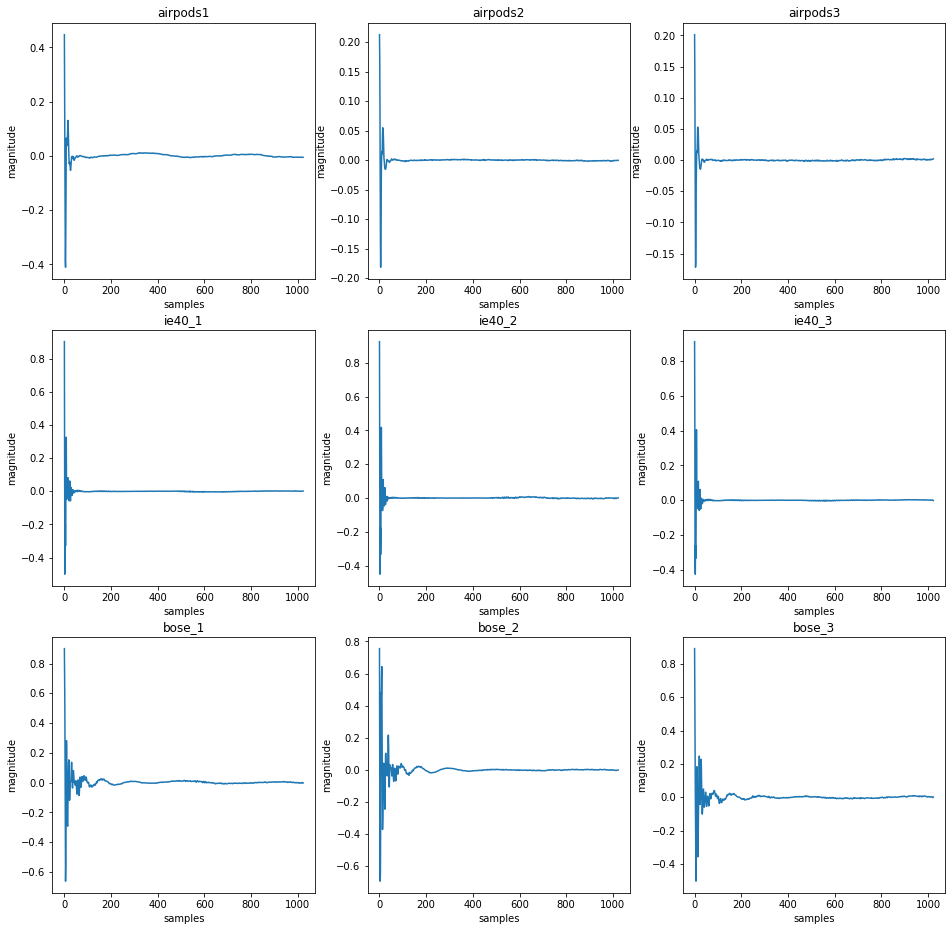

In [333]:
for i in range(1, samples_per_earphone + 1):
    _, ie40_audio = wavfile.read(folder_name+"ie40_"+str(i)+".wav")
    _, bose_audio = wavfile.read(folder_name+"bose800_"+str(i)+".wav")
    _, airpods_audio = wavfile.read(folder_name+"airpods_"+str(i)+".wav")
    ie40.append(ie40_audio)
    bose800.append(bose_audio)
    airpods.append(airpods_audio)

# _, ie40_1 = wavfile.read(folder_name+"ie40_1.wav")
# _, ie40_2 = wavfile.read(folder_name+"ie40_2.wav")
# _, ie40_3 = wavfile.read(folder_name+"ie40_3.wav")
# _, bose800_1 = wavfile.read(folder_name+"bose800_1.wav")
# _, bose800_2 = wavfile.read(folder_name+"bose800_2.wav")
# _, bose800_3 = wavfile.read(folder_name+"bose800_3.wav")
# _, airpods_1 = wavfile.read(folder_name+"airpods_1.wav")
# _, airpods_2 = wavfile.read(folder_name+"airpods_2.wav")
# _, airpods_3 = wavfile.read(folder_name+"airpods_3.wav")


# clip the played sound
# ie40_1 = clip_recording(ie40_1)
# ie40_2 = clip_recording(ie40_2)
# ie40_3 = clip_recording(ie40_3)
# sephia_1 = clip_recording(sephia_1)
# sephia_2 = clip_recording(sephia_2)
# sephia_3 = clip_recording(sephia_3)
# airpods_1 = clip_recording(airpods_1)
# airpods_2 = clip_recording(airpods_2)
# airpods_3 = clip_recording(airpods_3)
for i in range(samples_per_earphone):
    ie40[i] = clip_recording(ie40[i])
for i in range(samples_per_earphone):
    bose800[i] = clip_recording(bose800[i])
for i in range(samples_per_earphone):
    airpods[i] = clip_recording(airpods[i])
# display in time domain
plt.figure(figsize=(16, 16))
plot_audio(331, 'airpods1', airpods[0])
plot_audio(332, 'airpods2', airpods[3])
plot_audio(333, 'airpods3', airpods[4])
plot_audio(334, 'ie40_1', ie40[0])
plot_audio(335, 'ie40_2', ie40[3])
plot_audio(336, 'ie40_3', ie40[4])
plot_audio(337, 'bose_1', bose800[0])
plot_audio(338, 'bose_2', bose800[3])
plot_audio(339, 'bose_3', bose800[4])

# calculate cross correlation to check impulser response stability

In [334]:
def normalize(list_of_audios):
    result = []
    for audio in list_of_audios:
        norm = np.linalg.norm(audio)
        result.append(audio/norm)
    return result

In [335]:
def calc_corr_matrix(samples_per_earphone, impulse_responses):
    matrix = np.zeros((samples_per_earphone, samples_per_earphone))
    for i in range(samples_per_earphone):
        for j in range(samples_per_earphone):
            correlation = np.correlate(impulse_responses[i], impulse_responses[j])
            matrix[i, j] = float(correlation)
    return matrix

In [336]:
ie40_matrix = np.zeros((samples_per_earphone, samples_per_earphone))
airpods_matrix = np.zeros((samples_per_earphone, samples_per_earphone))
bose800_matrix = np.zeros((samples_per_earphone, samples_per_earphone))

In [337]:
# normalize the audio
ie40_norm = normalize(ie40)
airpods_norm = normalize(airpods)
bose800_norm = normalize(bose800)

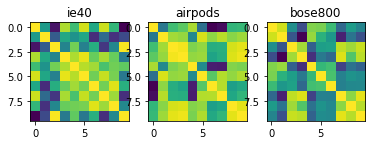

In [372]:
ie40_matrix = calc_corr_matrix(samples_per_earphone, ie40_norm)
airpods_matrix = calc_corr_matrix(samples_per_earphone, airpods_norm)
bose800_matrix = calc_corr_matrix(samples_per_earphone, bose800_norm)
plt.figure()
plt.subplot(131)
plt.title('ie40')
plt.imshow(ie40_matrix)
plt.subplot(132)
plt.title('airpods')
plt.imshow(airpods_matrix)
plt.subplot(133)
plt.title('bose800')
plt.imshow(bose800_matrix)

# Generate transfer funtions for each earphone
### Here only three earphones are used.
### Each earphone is measured by three times to make sure the feature of the estimated transfer function does not come from the noise channel

In [339]:
def generate_transfer(input_fft, output_audio):
    output_fft = np.fft.rfft(output_audio, fft_length)
    return output_fft / input_fft

frequency = np.linspace(0,fs/2,len(input_fft))
def plot_transfer(subplot_num, title, data, magnitude=True):
    plt.subplot(subplot_num)
    plt.title(title)
    plt.xlabel("frequency(Hz)")
    if (magnitude):
        plt.ylabel("magnitude(dB)")
    else:
        plt.ylabel("Phase(rad)")
    plt.plot(frequency, data)
    

In [340]:
# ie40_transfer_1 = generate_transfer(input_fft, ie40_1)
# ie40_transfer_2 = generate_transfer(input_fft, ie40_2)
# ie40_transfer_3 = generate_transfer(input_fft, ie40_3)

# sephia_transfer_1 = generate_transfer(input_fft, sephia_1)
# sephia_transfer_2 = generate_transfer(input_fft, sephia_2)
# sephia_transfer_3 = generate_transfer(input_fft, sephia_3)

# airpods_transfer_1 = generate_transfer(input_fft, airpods_1)
# airpods_transfer_2 = generate_transfer(input_fft, airpods_2)
# airpods_transfer_3 = generate_transfer(input_fft, airpods_3)

ie40_transfer = []
bose800_transfer = []
airpods_transfer = []
for i in range(samples_per_earphone):
    transfer = generate_transfer(input_fft, ie40_norm[i])
    ie40_transfer.append(transfer)
    transfer = generate_transfer(input_fft, airpods_norm[i])
    airpods_transfer.append(transfer)
    transfer = generate_transfer(input_fft, bose800_norm[i])
    bose800_transfer.append(transfer)

#### Below shows the magnitude of transfer functions of three earphones

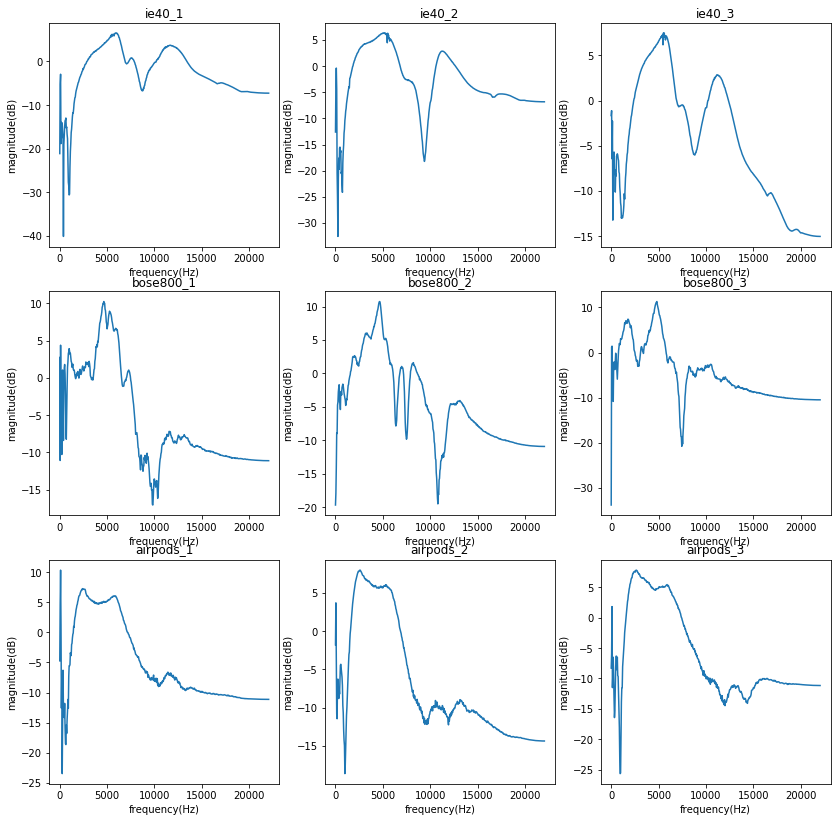

In [341]:
plt.figure(figsize=(14, 14))
plot_transfer(331, 'ie40_1', 20*np.log10(np.absolute(ie40_transfer[0])))
plot_transfer(332, 'ie40_2', 20*np.log10(np.absolute(ie40_transfer[1])))
plot_transfer(333, 'ie40_3', 20*np.log10(np.absolute(ie40_transfer[2])))
plot_transfer(334, 'bose800_1', 20*np.log10(np.absolute(bose800_transfer[0])))
plot_transfer(335, 'bose800_2', 20*np.log10(np.absolute(bose800_transfer[3])))
plot_transfer(336, 'bose800_3', 20*np.log10(np.absolute(bose800_transfer[4])))
plot_transfer(337, 'airpods_1', 20*np.log10(np.absolute(airpods_transfer[0])))
plot_transfer(338, 'airpods_2', 20*np.log10(np.absolute(airpods_transfer[1])))
plot_transfer(339, 'airpods_3', 20*np.log10(np.absolute(airpods_transfer[2])))

#### Below shows the phase of transfer functions of three earphones

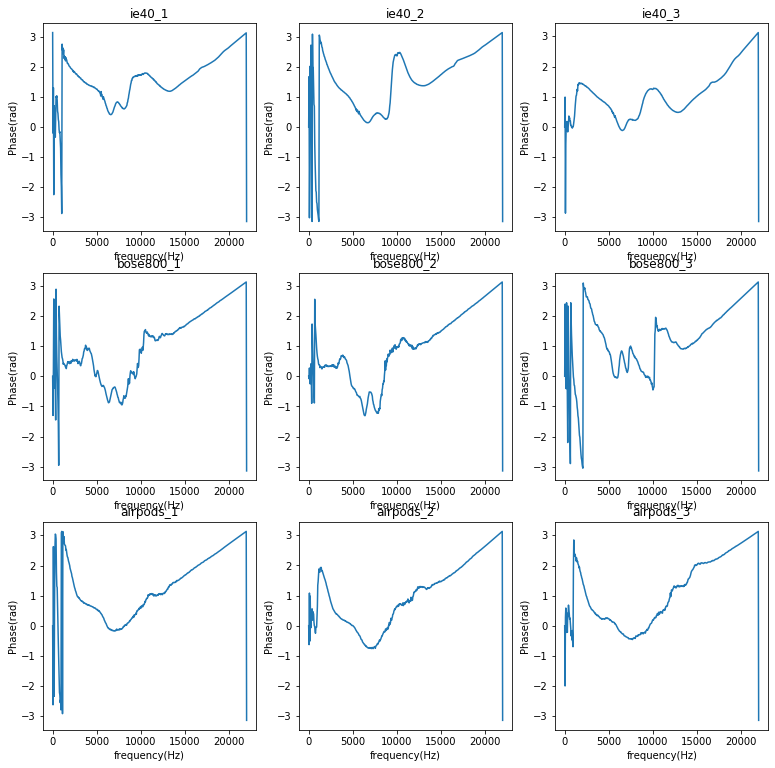

In [342]:
plt.figure(figsize=(13, 13))
plot_transfer(331, 'ie40_1', np.angle(ie40_transfer[0]), 0)
plot_transfer(332, 'ie40_2', np.angle(ie40_transfer[1]), 0)
plot_transfer(333, 'ie40_3', np.angle(ie40_transfer[2]), 0)
plot_transfer(334, 'bose800_1', np.angle(bose800_transfer[0]), 0)
plot_transfer(335, 'bose800_2', np.angle(bose800_transfer[1]), 0)
plot_transfer(336, 'bose800_3', np.angle(bose800_transfer[2]), 0)
plot_transfer(337, 'airpods_1', np.angle(airpods_transfer[0]), 0)
plot_transfer(338, 'airpods_2', np.angle(airpods_transfer[1]), 0)
plot_transfer(339, 'airpods_3', np.angle(airpods_transfer[2]), 0)

# Prepare the training data

In [343]:
print(np.absolute(ie40_transfer).shape)
print(np.angle(ie40_transfer).shape)

(10, 513)
(10, 513)


In [344]:
def generate_train(transfer, class_index, num_classes, sparse=1):
    magnitude = 20*np.log10(np.absolute(transfer))
    phase = np.angle(transfer)
    train_x = np.concatenate((magnitude, phase), axis=-1)
    train_y = np.zeros((samples_per_earphone, num_classes))
    train_y[:, class_index] += 1
    if (sparse==0):
        train_y = np.zeros(samples_per_earphone)
        train_y += class_index
    return train_x, train_y
# def generate_train(transfer, class_index, num_classes):
#     magnitude = 20*np.log10(np.absolute(transfer))
#     phase = np.angle(transfer)
#     train_x = transfer
#     train_y = np.zeros((samples_per_earphone, num_classes))
#     train_y[:, class_index] += 1
#     return train_x, train_y

In [345]:
ie40_train_x, ie40_train_y = generate_train(ie40_transfer, 0, 3)
bose800_train_x, bose800_train_y = generate_train(bose800_transfer, 1, 3)
airpods_train_x, airpods_train_y = generate_train(airpods_transfer, 2, 3)
train_x = np.concatenate((ie40_train_x, bose800_train_x, airpods_train_x), axis=0) # [#training_size, #features]
train_y = np.concatenate((ie40_train_y, bose800_train_y, airpods_train_y), axis=0) # [#training_size, #classes]
train_y_not_sparse = np.argmax(train_y, axis=-1) # [#training_size]

# Use multiclass classifier to classify earphones

In [346]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [362]:
def train(model, data, label, rounds, num_classes):
    scores = []
    num_data = data.shape[0]
    training_size = int(num_data * 0.8)
    validation_size = int(num_data - training_size)
    for i in range(rounds):
        shuffle_index = np.random.permutation(data.shape[0])
        x = data[shuffle_index]
        y = label[shuffle_index]
        train_x = x[:training_size]
        train_y = y[:training_size]
        val_x = x[training_size+1:]
        val_y = y[training_size+1:]
        model.fit(train_x, train_y)
        score = model.score(val_x, val_y)
        scores.append(score)
    accuracy = np.mean(scores)
    return accuracy

In [369]:
knn = KNeighborsClassifier(n_neighbors=4)
lr_model = LogisticRegression(random_state=0, multi_class='auto', solver='lbfgs', max_iter=500)

In [370]:
knn_score = train(knn, train_x, train_y, 5, 3)
lr_score = train(lr_model, train_x, train_y_not_sparse, 5, 3)

In [371]:
print('knn score', knn_score)
print('linear regression score', lr_score)

knn score 0.96
linear regression score 1.0
